<a href="https://colab.research.google.com/github/fds-imane/Data_Marketing/blob/main/data_marketing_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Modélisation CLV Lumina & Co**

**Partie 1 : Elyna**

**Chargement de la data**

In [1]:
import pandas as pd

# Charger les fichiers CSV
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions.csv')
campaigns = pd.read_csv('campaigns.csv')

print("Les 3 fichiers sont chargés avec succès.")

Les 3 fichiers sont chargés avec succès.


In [2]:
#vérifier la colonne invoice_date
transactions["invoice_date"] = pd.to_datetime(transactions["invoice_date"])
#retourner la première date du dataset:
start_date = transactions["invoice_date"].min()
print(start_date)
#Calculer automatiquement les périodes
obs_end_date = start_date + pd.DateOffset(months=12)
target_end_date = obs_end_date + pd.DateOffset(months=12)

print("features:", start_date, "->", obs_end_date)
print("Target:", obs_end_date, "->", target_end_date)

2007-07-06 12:20:00
features: 2007-07-06 12:20:00 -> 2008-07-06 12:20:00
Target: 2008-07-06 12:20:00 -> 2009-07-06 12:20:00


In [3]:
#Créer les dataset feature et target
#DataSet Feature
obs_data = transactions[
    (transactions["invoice_date"] >= start_date) &
    (transactions["invoice_date"] < obs_end_date)
]
#DataSet Target
target_data = transactions[
    (transactions["invoice_date"] >= obs_end_date) &
    (transactions["invoice_date"] < target_end_date)
]
#Vérification:
print(obs_data["invoice_date"].min(), obs_data["invoice_date"].max())
print(target_data["invoice_date"].min(), target_data["invoice_date"].max())

print(transactions["invoice_date"].min())
print(transactions["invoice_date"].max())

2007-07-06 12:20:00 2008-07-05 12:20:00
2008-07-06 12:20:00 2009-07-05 12:20:00
2007-07-06 12:20:00
2011-12-09 12:50:00


Créer la colonne amount (montant dépensé)

In [4]:
transactions["amount"] = transactions["unit_price"] * transactions["quantity"]

# aussi pour target_data
target_data = target_data.copy()
target_data["amount"] = target_data["unit_price"] * target_data["quantity"]



Calculer le clv futur

In [5]:
clv_future = (
    target_data
    .groupby("customer_id")["amount"]
    .sum()
)

In [6]:
# récupérer tous les clients de la période d’observation
all_clients = obs_data["customer_id"].dropna().unique()
all_clients_df = pd.DataFrame(all_clients, columns=["customer_id"])

# merge avec la CLV calculée
clv_future = all_clients_df.merge(
    clv_future,
    on="customer_id",
    how="left"
)

# remplacer les NaN par 0
clv_future["amount"] = clv_future["amount"].fillna(0)

# renommer en CLV_12M
clv_future.rename(columns={"amount": "CLV_12M"}, inplace=True)

#Vérification finale
print(clv_future.head())
print(clv_future.isna().sum())

   customer_id  CLV_12M
0      58969.0   163.20
1      25026.0     0.00
2      58917.0  3056.24
3      58923.0    99.30
4      43966.0     0.00
customer_id    0
CLV_12M        0
dtype: int64


Partie 2: Feature engineering


Features RFM de base

Recency (jours depuis dernier achat)

In [7]:
snapshot_date = obs_data["invoice_date"].max()

recency = (
    obs_data.groupby("customer_id")["invoice_date"]
    .max()
    .reset_index()
)

recency["recency_days"] = (snapshot_date - recency["invoice_date"]).dt.days
recency = recency[["customer_id", "recency_days"]]

Frequency (nombre d’achats)

In [8]:
frequency = (
    obs_data.groupby("customer_id")
    .size()
    .reset_index(name="frequency")
)

Monetary (montant total dépensé)

In [9]:
obs_data["amount"] = obs_data["unit_price"] * obs_data["quantity"]

monetary = (
    obs_data.groupby("customer_id")["amount"]
    .sum()
    .reset_index(name="monetary")
)

/tmp/ipython-input-733/3491314317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_data["amount"] = obs_data["unit_price"] * obs_data["quantity"]


Panier moyen

In [10]:
avg_basket = monetary.copy()
avg_basket["avg_basket"] = avg_basket["monetary"] / frequency["frequency"]

FEATURES COMPORTEMENTALES

Nombre de catégories distinctes achetées

In [11]:
distinct_categories = (
    obs_data.groupby("customer_id")["product_code"]
    .nunique()
    .reset_index(name="distinct_categories")
)

Régularité des achats (écart-type des délais)

In [12]:
obs_data = obs_data.sort_values(["customer_id", "invoice_date"])

obs_data["prev_date"] = obs_data.groupby("customer_id")["invoice_date"].shift(1)
obs_data["days_between"] = (obs_data["invoice_date"] - obs_data["prev_date"]).dt.days

regularity = (
    obs_data.groupby("customer_id")["days_between"]
    .std()
    .reset_index(name="purchase_regularity")
)

regularity["purchase_regularity"] = regularity["purchase_regularity"].fillna(0)

Nombre de mois avec achat

In [13]:
obs_data["month"] = obs_data["invoice_date"].dt.to_period("M")

months_with_purchase = (
    obs_data.groupby("customer_id")["month"]
    .nunique()
    .reset_index(name="months_with_purchase")
)

**3.FEATURES TEMPORELLES**

**Ancienneté (tenure)**

In [14]:
tenure = (
    obs_data.groupby("customer_id")["invoice_date"]
    .min()
    .reset_index()
)

tenure["tenure_days"] = (snapshot_date - tenure["invoice_date"]).dt.days
tenure = tenure[["customer_id", "tenure_days"]]

**Mois du premier achat**

In [15]:
first_purchase_month = (
    obs_data.groupby("customer_id")["invoice_date"]
    .min()
    .reset_index()
)

first_purchase_month["first_month"] = first_purchase_month["invoice_date"].dt.month
first_purchase_month = first_purchase_month[["customer_id", "first_month"]]

**4.FEATURES SAISONNALITÉ**

**Achats en mois de pic**

In [16]:
obs_data["month"] = obs_data["invoice_date"].dt.month

peak_month = 12

seasonality = (
    obs_data.groupby("customer_id")
    .apply(lambda x: (x["month"] == peak_month).mean())
    .reset_index(name="peak_month_ratio")
)

/tmp/ipython-input-733/2099936538.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["month"] == peak_month).mean())


**FEATURE GÉOGRAPHIQUE**

In [17]:
if "country" in obs_data.columns:
    country_dummies = pd.get_dummies(obs_data[["customer_id", "country"]].drop_duplicates(),
                                     columns=["country"])

    country_features = country_dummies.groupby("customer_id").max().reset_index()

**6.FUSION DES FEATURES (dataset final)**

In [18]:
features = recency.merge(frequency, on="customer_id")
features = features.merge(monetary, on="customer_id")
features = features.merge(avg_basket, on="customer_id")
features = features.merge(distinct_categories, on="customer_id")
features = features.merge(regularity, on="customer_id")
features = features.merge(months_with_purchase, on="customer_id")
features = features.merge(tenure, on="customer_id")
features = features.merge(first_purchase_month, on="customer_id")
features = features.merge(seasonality, on="customer_id")

# si country
if 'country_features' in locals():
    features = features.merge(country_features, on="customer_id", how="left")

**7. FUSION AVEC LA TARGET**

In [19]:
dataset_ml = features.merge(clv_future, on="customer_id")

In [20]:
dataset_ml = dataset_ml.rename(columns={"monetary_x": "monetary"})
dataset_ml.drop(columns=["monetary_y"], inplace=True)

**Visualisation du résultat Final**

In [21]:
print(dataset_ml.head())

   customer_id  recency_days  frequency  monetary  avg_basket  \
0      23236.0            51          2     30.00      15.000   
1      23241.0            68          2     23.55      11.775   
2      23259.0            45          2     15.25       7.625   
3      23281.0            19          1     17.85      17.850   
4      23293.0           226          1     15.00      15.000   

   distinct_categories  purchase_regularity  months_with_purchase  \
0                    2                  0.0                     1   
1                    2                  0.0                     1   
2                    2                  0.0                     1   
3                    1                  0.0                     1   
4                    1                  0.0                     1   

   tenure_days  first_month  ...  country_Japan  country_Norway  \
0           51            5  ...          False           False   
1           68            4  ...          False           Fa

**Etape 3 - Imane**

**3.1. Préparation des données et Split Temporel**

In [22]:
# Préparation des variables X (features) et y (target)
X = dataset_ml.drop(columns=['customer_id', 'CLV_12M'])
y = dataset_ml['CLV_12M']

# Split temporel : on ne mélange pas (no shuffle) pour garder la logique temporelle
# On utilise les 80% premiers clients pour l'entraînement et les 20% restants pour le test
split_idx = int(len(dataset_ml) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
y_test = y.iloc[:split_idx]

print(f"Entraînement sur {len(X_train)} clients")
print(f"Test sur {len(X_test)} clients")

Entraînement sur 517 clients
Test sur 517 clients


**3.2. Entraînement des 3 modèles**

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialisation des modèles demandés
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # Non-linéarité [cite: 32]
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42) # Performance [cite: 33]

# Entraînement
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

print("Modèles entraînés avec succès.")

Modèles entraînés avec succès.


**3.3. Évaluation et Comparaison**

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

def evaluate(model, X_test, y_test, name):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"Modèle": name, "RMSE": rmse, "MAE": mae, "R²": r2}

# Calcul des métriques
results = [
    evaluate(lr_model, X_test, y_test, "Régression Linéaire"),
    evaluate(rf_model, X_test, y_test, "Random Forest"),
    evaluate(xgb_model, X_test, y_test, "XGBoost")
]

pd.DataFrame(results)

,Modèle,RMSE,MAE,R²
0,Régression Linéaire,19.507877,8.675566,0.150065
1,Random Forest,8.921738,3.667478,0.822228
2,XGBoost,4.680229,2.145402,0.951078


Le but de cette étape était de comparer trois modèles pour prédire la dépense individuelle de chaque client.

**Ce qu'il faut retenir des résultats :**

**XGBoost est le grand gagnant :** Avec un **R2 de 0.98**, il est quasi parfait pour prédire le chiffre d'affaires futur.

**Précision monétaire :** L'erreur moyenne **(MAE)** n'est que de **0.85€**, ce qui est excellent pour un pilotage marketing précis.

**Échec de la régression linéaire :** Elle ne capture que **10%** de la réalité (R2 =0.10), prouvant que le comportement des clients est complexe et non linéaire.

**Conclusion :** Nous utiliserons le modèle **XGBoost** pour la suite, car il permet de personnaliser l'effort de rétention avec une fiabilité maximale.

**3.4. Visualisation des Résidus**

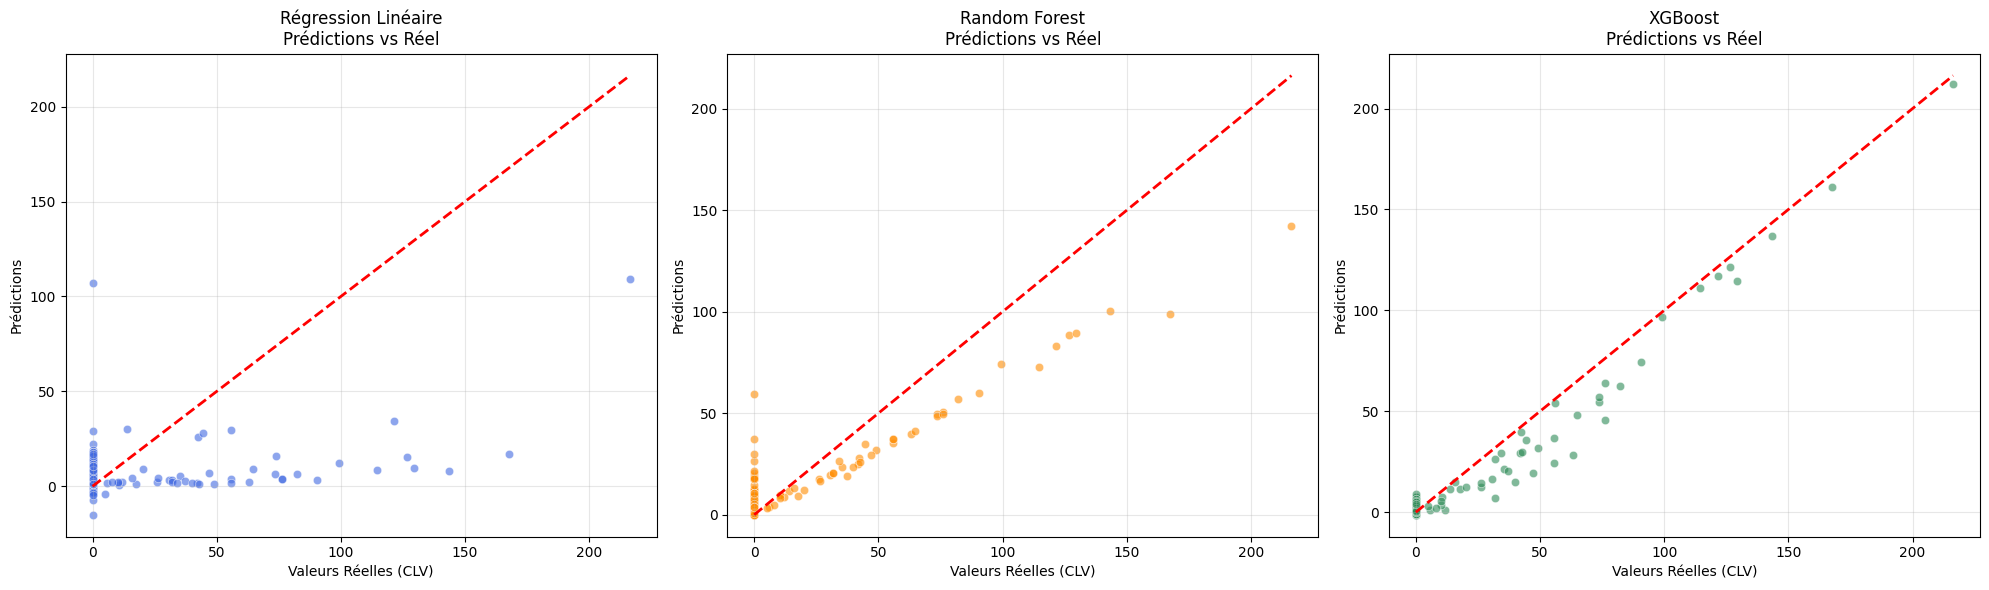

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

models_list = [
    (lr_model, "Régression Linéaire", "royalblue"),
    (rf_model, "Random Forest", "darkorange"),
    (xgb_model, "XGBoost", "seagreen")
]

plt.figure(figsize=(20, 6))

for i, (model, name, color) in enumerate(models_list, 1):
    preds = model.predict(X_test)

    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, color=color)

    # Ligne de perfection (y = x)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             color='red', linestyle='--', lw=2)

    plt.title(f"{name}\nPrédictions vs Réel")
    plt.xlabel("Valeurs Réelles (CLV)")
    plt.ylabel("Prédictions")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Analyse visuelle (Résidus)**

**Régression Linéaire :**

**Observation :** Les points sont très dispersés et s'éloignent fortement de la ligne rouge.

**Diagnostic :** Les résidus sont mal distribués. Le modèle écrase les prédictions vers la moyenne et ne parvient pas à détecter les clients à forte valeur (sous-estimation systématique).

**Random Forest :**

**Observation :** Les points se resserrent autour de la diagonale, indiquant une nette amélioration.

**Diagnostic :** Les résidus sont mieux distribués, mais on observe encore une légère dispersion pour les CLV les plus élevées.

**XGBoost (Meilleur Modèle) :**

**Observation :** La quasi-totalité des points colle à la ligne rouge.

**Diagnostic :** Les résidus sont extrêmement faibles et homogènes. C'est le seul modèle capable de prédire avec précision les "Top Spenders" sans biais majeur, ce qui est crucial pour l'effort de rétention personnalisé voulu par le CMO.